<a href="https://colab.research.google.com/github/SerSanC/Word2Vec-Simpson-Project/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser

import spacy  # For preprocessing
import multiprocessing

from gensim.models import Word2Vec

In [2]:
!python -m spacy download en_core_web_sm

2022-10-18 07:07:33.395831: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


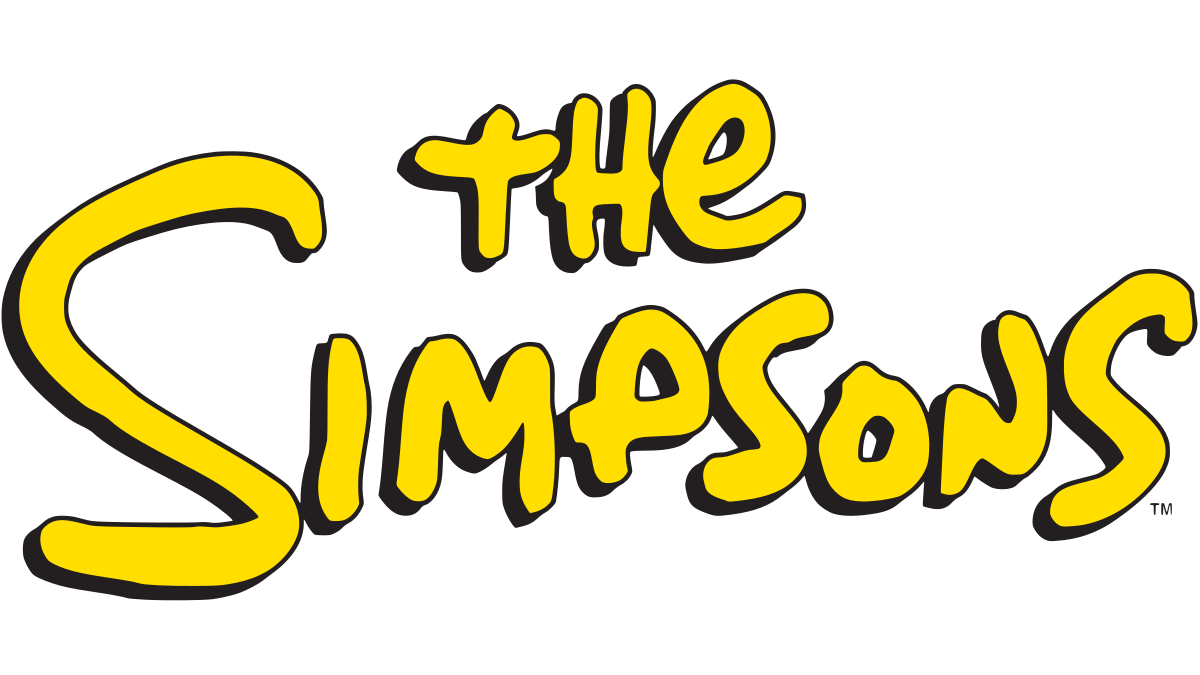

# The Data

The Simpsons is an American animated sitcom created by Matt Groening for the Fox Broadcasting Company. The series is a satirical depiction of American life, epitomized by the Simpson family, which consists of Homer, Marge, Bart, Lisa, and Maggie. The show is set in the fictional town of Springfield and parodies American culture and society, television, and the human condition. 

This dataset contains the character who speaks and the raw text from the line of dialogue. It can be found here: 

https://www.kaggle.com/datasets/pierremegret/dialogue-lines-of-the-simpsons

# Preprocessing

In [3]:
from google.colab import files

uploaded = files.upload()

Saving simpsons_dataset.csv to simpsons_dataset.csv


In [4]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [5]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [6]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [7]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Cleaning:

It consists of lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [8]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [9]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [10]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.9 mins


Add the results to a DataFrame to remove missing and duplicate values:

In [11]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85954, 1)

## Bigrams:

Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson".

In [12]:
sent = [row.split() for row in df_clean['clean']]

In [13]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [14]:
bigram = Phraser(phrases)

In [15]:
sentences = bigram[sent]

## Word 

In [16]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29674

In [17]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

# Training the model

In [18]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [19]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [20]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.05 mins


In [21]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.61 mins


## Exploring the model
### Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

In [22]:
w2v_model.wv.most_similar(positive=["homer"])

[('sweetheart', 0.8023964166641235),
 ('marge', 0.7958885431289673),
 ('gee', 0.7863509654998779),
 ('depressed', 0.7793607711791992),
 ('snuggle', 0.7638195753097534),
 ('bongo', 0.744521975517273),
 ('hammock', 0.7425088882446289),
 ('creepy', 0.7371652126312256),
 ('drunk', 0.7368977069854736),
 ('crummy', 0.7351188659667969)]

In [23]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('council', 0.7986871004104614),
 ('recent', 0.7938088774681091),
 ('congratulation', 0.7892942428588867),
 ('select', 0.788150429725647),
 ('robert', 0.778351902961731),
 ('pleased', 0.7737969160079956),
 ('sir', 0.7688939571380615),
 ('burns', 0.7608059048652649),
 ('governor', 0.758185625076294),
 ('united_states', 0.7419785261154175)]

In [42]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.7958886623382568),
 ('snuggle', 0.7847324013710022),
 ('married', 0.7769250869750977),
 ('darling', 0.7543584108352661),
 ('brunch', 0.7526756525039673),
 ('sure', 0.7510753870010376),
 ('husband', 0.7505837678909302),
 ('sorry', 0.7505831718444824),
 ('homie', 0.7462124228477478),
 ('ohh', 0.7428195476531982)]

In [25]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8345832824707031),
 ('mom', 0.7741888761520386),
 ('upset', 0.7736644744873047),
 ('convince', 0.769268274307251),
 ('badly', 0.7612825036048889),
 ('dr_hibbert', 0.7578321695327759),
 ('janey', 0.755243718624115),
 ('jealous', 0.7511260509490967),
 ('milhouse', 0.7447141408920288),
 ('creepy', 0.7439168691635132)]


## Similarities:

Here, we will see how similar are two words to each other :


In [31]:
w2v_model.wv.similarity('maggie', 'baby')

0.6904268

In [33]:
w2v_model.wv.similarity('bart', 'milhouse')

0.74471426

In [38]:
w2v_model.wv.similarity('homer', 'marge')

0.7958886

In [39]:
w2v_model.wv.similarity('homer', 'patty')

0.34921566

In [51]:
w2v_model.wv.similarity('milhouse', 'patty')

0.30685303

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

In [36]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [37]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [40]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma','marge'])

'homer'

## Analogy difference:

In [55]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=5)

[('lisa', 0.7234850525856018),
 ('pregnant', 0.6973482370376587),
 ('father', 0.6964823007583618),
 ('parent', 0.691489577293396),
 ('jealous', 0.6714439392089844)]

In [59]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["milhouse"], topn=3)

[('rude', 0.6430022716522217),
 ('wife', 0.6414204835891724),
 ('marge', 0.6134703159332275)]